<a href="https://colab.research.google.com/github/MJMortensonWarwick/large_scale_data_for_research/blob/main/graph_databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Databases with CogniPy
This notebook shows, with a significant amount of hand waving, the functionality of a graph database, using another Python-based, in-memory database [CogniPy](https://github.com/cognitum-octopus/cognipy).

This is a simplied version of a tutorial from their documentation, but many details are going to be glossed over as not strictly neccessary to proceed - but do go through the docs if interested.

We'll being by installing the pre-requsistes (including Linux pre-requisites):

In [ ]:
!sudo apt install ca-certificates gnupg
!sudo gpg --homedir /tmp --no-default-keyring --keyring /usr/share/keyrings/mono-official-archive-keyring.gpg --keyserver hkp://keyserver.ubuntu.com:80 --recv-keys 3FA7E0328081BFF6A14DA29AA6A19B38D3D831EF
!echo "deb [signed-by=/usr/share/keyrings/mono-official-archive-keyring.gpg] https://download.mono-project.com/repo/ubuntu stable-focal main" | sudo tee /etc/apt/sources.list.d/mono-official-stable.list
!sudo apt update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ca-certificates is already the newest version (20230311ubuntu0.20.04.1).
gnupg is already the newest version (2.2.19-3ubuntu2.2).
gnupg set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
gpg: keybox '/usr/share/keyrings/mono-official-archive-keyring.gpg' created
gpg: /tmp/trustdb.gpg: trustdb created
gpg: key A6A19B38D3D831EF: public key "Xamarin Public Jenkins (auto-signing) <releng@xamarin.com>" imported
gpg: Total number processed: 1
gpg:               imported: 1
deb [signed-by=/usr/share/keyrings/mono-official-archive-keyring.gpg] https://download.mono-project.com/repo/ubuntu stable-focal main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 https://download.mono-project.com/repo/ubuntu stable-focal InRelease [4,416

In [ ]:
!sudo apt install mono-devel

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  binfmt-support ca-certificates-mono cli-common libgdiplus libmono-2.0-dev
  libmono-accessibility4.0-cil libmono-btls-interface4.0-cil
  libmono-cairo4.0-cil libmono-cecil-private-cil libmono-cil-dev
  libmono-codecontracts4.0-cil libmono-compilerservices-symbolwriter4.0-cil
  libmono-corlib4.5-cil libmono-cscompmgd0.0-cil libmono-csharp4.0c-cil
  libmono-custommarshalers4.0-cil libmono-data-tds4.0-cil libmono-db2-1.0-cil
  libmono-debugger-soft4.0a-cil libmono-http4.0-cil libmono-i18n-cjk4.0-cil
  libmono-i18n-mideast4.0-cil libmono-i18n-other4.0-cil
  libmono-i18n-rare4.0-cil libmono-i18n-west4.0-cil libmono-i18n4.0-all
  libmono-i18n4.0-cil libmono-ldap4.0-cil libmono-management4.0-cil
  libmono-messaging-rabbitmq4.0-cil libmono-messaging4.0-cil
  libmono-microsoft-build-engine4.0-cil
  libmono-microsoft-build-framework4.0-cil
  libmo

In [ ]:
!pip install cognipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00


With everything installed we can begin. CogniPy allows us some cool tricks - particularly natural language graph specification, Pandas-integration, and some nice graph visulisations:

In [ ]:
from cognipy.ontology import Ontology # the ontology processing class
from cognipy.ontology import CQL # SPARQL format tailored for Contolled Natural Language
from cognipy.ontology import encode_string_for_graph_label # complex datatypes encoder for the graph labels in graph visualisation
import textwrap
import pandas as pd

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

Our graph and database "rules" are defined via an _encnl_ file which details our ontology:

In [ ]:
%%writefile Simple_IT_01.encnl
Title: 'Simple IT Infrastructure'.
Author: 'Cognitum'.

Comment: 'Sample IT ontology'.
Namespace: 'http://ontorion.com/IT_Infra'.

Part-1:  Server--------------------------------.
Comment: ////// Examples of Possible Questions ////////////
 * Who-Or-What is a server ?
 * Who-Or-What is hosted by Server-1 ?
 * Who-Or-What runs-on Server-2 ?
//////////////////////////////////////////////////////////.

Server-1 is a server.
Server-1 hosts Application-1.
Application-3 is hosted by Server-1.

Server-2 is a server.
Server-2 hosts Application-2.

Every server should host an application.
Every server must have-status a thing that is either Operable or Inoperable.

If a server hosts an application then the application runs-on the server.

Part-2: Application---------------------------.
Comment: ////// Examples of Possible Questions ////////////
 * Who-Or-What serves a customer ?
 * Who-Or-What serves Customer-1 ?
 * Who-Or-What is served by Application-2 ?
///////////////////////////////////////////////////////////.

Application-1 is an application.
Application-1 serves Customer-1.

Application-2 is an application.
Application-2 serves Customer-1 and serves Customer-2.

Application-3 is an application.

Every application can serve a customer.
Every application must be hosted by a server.

Every application must have-status a thing that is either Operable or Inoperable.

Part-3: Customers------------------------------.
Comment: ////// Examples of Possible Questions ////////////
 * Who-Or-What is a customer that has-priority Low ?
 * Who-Or-What is a high-priority-customer ?
 * Who-Or-What serves a customer that has-priority Critical ?
 * Who-Or-What serves a customer that is a high-priority-customer ?
//////////////////////////////////////////////////////////.

Customer-1 is a customer.
Customer-1 has-priority Critical.

Customer-2 is a customer.
Customer-2 has-priority Medium.

Customer-3 is a customer and has-priority Low.

Customer-4 is a customer and has-priority Critical.


Every customer must have-priority a priority.
Something is a priority if-and-only-if-it is either Critical or Medium or Low.
Every customer that has-priority Critical is a high-priority-customer.

Part-4: Power Node------------------------------.
Comment: ////// Examples of Possible Questions ////////////
 * Who-Or-What connects Server-1?
 * Who-Or-What is connected by Powernode-1?
//////////////////////////////////////////////////////////.

Powernode-1 is a powernode.
Powernode-1 connects Server-1.

Powernode-2 is a powernode.
Powernode-2 connects Server-1.

Powernode-3 is a powernode.
Powernode-3 connects Server-2.

Powernode-4 is a powernode.
Powernode-4 connects Server-2.

Every powernode connects nothing-but server.
Every powernode must have-status a thing that is either Operable or Inoperable.

Writing Simple_IT_01.encnl


With this ontology in place we can build our graph:

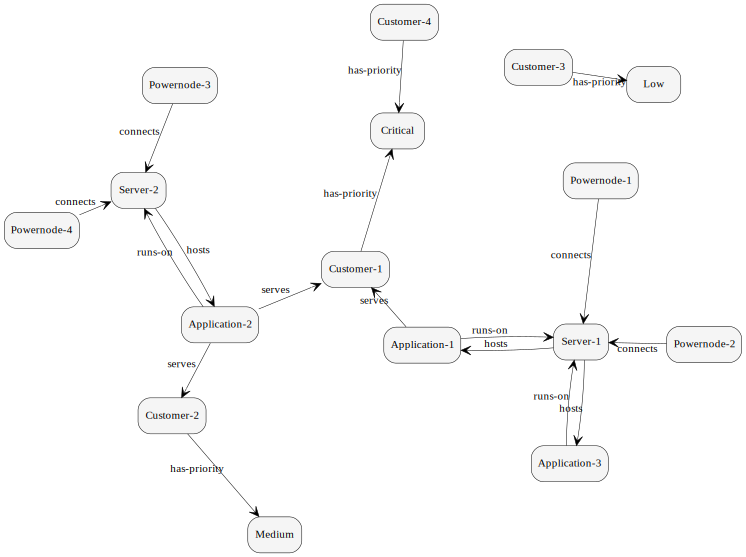

In [ ]:
onto=Ontology("cnl/file","Simple_IT_01.encnl",
                    evaluator = lambda e:eval(e,globals(),locals()),
                    graph_attribute_formatter = graph_attribute_formatter)
onto.draw_graph(layout='force directed',show={"relations"})

As can be seen we have a series of entities (severs, customers, etc.), connected with different edges ("serves", "hosts", etc.). We can query these entities with the _select\_instances\_of_ function:

In [ ]:
applications=onto.select_instances_of("application")
servers=onto.select_instances_of("server")
customers=onto.select_instances_of("customer")
powernodes=onto.select_instances_of("powernode")
status=onto.select_instances_of("priority")

In [ ]:
display(customers)

,Instance,has-priority
0,Customer-4,Critical
1,Customer-3,Low
2,Customer-2,Medium
3,Customer-1,Critical


This approach can also be used to create (slightly) more complex queries and outputs:

In [ ]:
print(onto.select_instances_of("a thing that serves a customer")[["Instance","serves"]])

        Instance                    serves
0  Application-2  [Customer-2, Customer-1]
1  Application-3                      None
2  Application-1                Customer-1


Native support for Pandas allows us to quickly create dataframes:

In [ ]:
df = pd.DataFrame(data=applications["Instance"])
display(df)

# print elements of ontology using the for loop
for item in df['Instance']:
    print(item)

,Instance
0,Application-3
1,Application-2
2,Application-1


Application-3
Application-2
Application-1


... and gives us access to other Pandas' data manipulation functionalities:

In [ ]:
df = pd.DataFrame(
  {"Powernode": powernodes['Instance'], "Server": powernodes['connects']})

print("Normal df")
display(df)

print("\n")
print("Group by df")

dfgb = df.groupby("Server").sum()
display(dfgb)

Normal df


,Powernode,Server
0,Powernode-4,Server-2
1,Powernode-3,Server-2
2,Powernode-2,Server-1
3,Powernode-1,Server-1




Group by df


,Powernode
Server,
Server-1,Powernode-2Powernode-1
Server-2,Powernode-4Powernode-3


So as promised, lot's of hand waving and detail ignored, but hopefuly a quick insight into how a graph database may work.